In [73]:
import matplotlib.pyplot as plt
import math
from qutip import (destroy, tensor, basis, fidelity, Bloch,
                   average_gate_fidelity,
                   Options, ket2dm, rand_dm, sigmaz)
from chalmers_qubit.processor import ChalmersQubits
from qutip_qip.circuit import QubitCircuit, Gate
from qutip_qip.operations import rz, rx, ry
from qutip_qip.compiler import Scheduler, Instruction
from qutip import Qobj
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test Single Qubit Gates

In [37]:
# Define a circuit and run the simulation
num_qubits = 2
circuit = QubitCircuit(num_qubits)

# Create the Hadamard Gate
circuit.add_gate("RY", targets=0, arg_value=np.pi/2)
circuit.add_gate("RY", targets=1, arg_value=np.pi/2)
#circuit.add_gate("RX", targets=0, arg_value=np.pi)
circuit.add_gate("GLOBALPHASE", targets=0, arg_value=np.pi/2)

In [14]:
t1 = 1 * 10**3 # nano seconds
t2 = 1.5 * 10**3 # nano seconds

myprocessor = ChalmersQubits(num_qubits, t1=t1, t2=t2)
tlist, coeffs = myprocessor.load_circuit(circuit)

0.006283185307179587


In [15]:
myprocessor.ctrls[0]

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  1.41421356 0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         1.41421356 0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         1.41421356]
 [0.         0.         0.         1.41421356 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.41421356 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.41421356
  0.         0.         0.        ]]

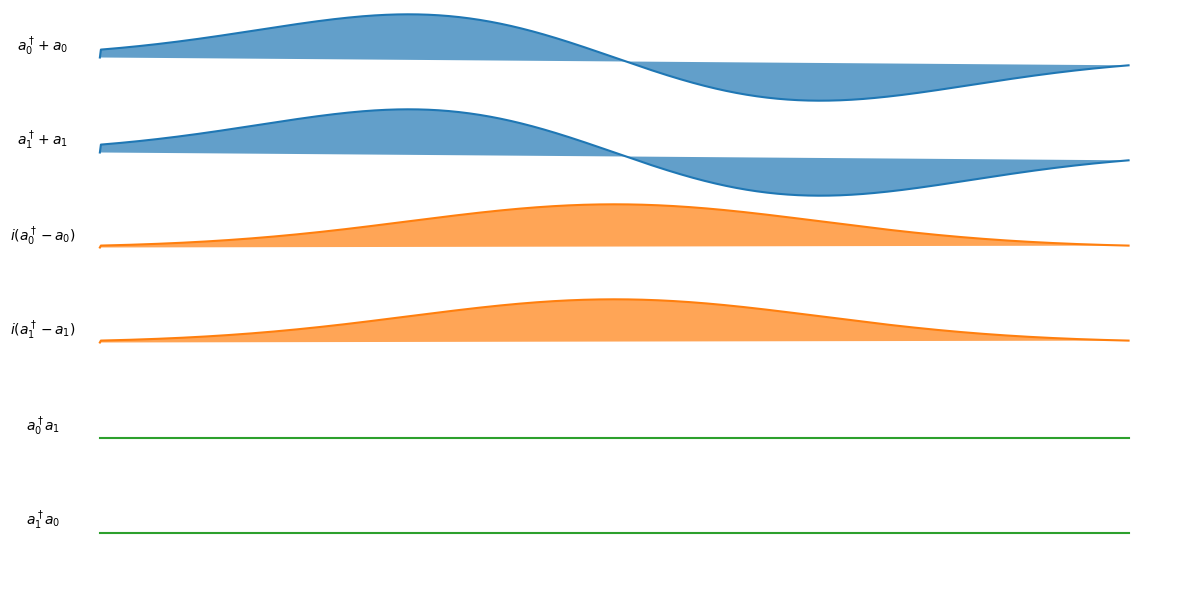

In [16]:
myprocessor.plot_pulses()
plt.show()

### Quantum State Simulation

In [17]:
initial_state = tensor(basis(3, 0), basis(3, 0))
result = myprocessor.run_state(initial_state)
final_state = result.states[-1]
final_state

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 2.63454136e-01-5.91179040e-20j  2.53438072e-01+5.94886273e-03j
  -4.62021488e-05-2.63207089e-04j  2.53438072e-01+5.94886273e-03j
   2.43668306e-01+1.14453944e-02j -3.84959722e-05-2.54242108e-04j
  -4.62021488e-05-2.63207089e-04j -3.84959722e-05-2.54242108e-04j
  -2.94979037e-07+4.93970133e-08j]
 [ 2.53438072e-01-5.94886273e-03j  2.49823137e-01+1.92373939e-19j
  -5.16511518e-05-2.58239620e-04j  2.43936961e-01+7.51881353e-19j
   2.40325112e-01+5.64108302e-03j -4.38500583e-05-2.49585116e-04j
  -5.03822860e-05-2.52156747e-04j -4.37987233e-05-2.49585340e-04j
  -2.78935975e-07+5.68363371e-08j]
 [-4.62021488e-05+2.63207089e-04j -5.16511518e-05+2.58239620e-04j
   5.59599682e-07+8.36101017e-21j -5.03822860e-05+2.52156747e-04j
  -5.55119090e-05+2.47253665e-04j  5.38408649e-07+1.26389378e-08j
   2.71058952e-07+3.62151300e-21j  2.67141972e-07+6.32504155e-09j
  -4.32899060e-11-5.83485085e-10j]
 [ 2.53

In [18]:
# Project final state to the qubit subspace
def project_on_qubit(rho: Qobj) -> Qobj:
     """
     Project a given quantum object (density matrix or state vector) onto the computational basis of qubits.

     Parameters
     ----------
     rho : Qobj
         The input quantum object, either a density matrix ('oper' type) or a state vector.

     Returns
     -------
     qubit_state : Qobj
         The projected quantum object onto the computational basis (0 and 1 states) of qubits.
     """
     num_qubits = len(rho.dims[0])
     # Generate all states for N levels in base 3
     base_N = [np.base_repr(i, base=3) for i in range(3**num_qubits)]
     # Generate all computational basis states in base 2
     base_2 = [np.base_repr(i, base=2) for i in range(2**num_qubits)]
     # Find indices of computational basis states in base N list
     l = [base_N.index(i) for i in base_2]
     if rho.type == 'oper':
         # If rho is a density matrix, project it onto the computational basis
         qubit_state = Qobj([[rho.data[j, i] for i in l] for j in l], dims=[
                            [2] * num_qubits, [2] * num_qubits])
     else:
         # If rho is a state vector, project it onto the computational basis
         qubit_state = Qobj([rho.full()[j] for j in l], dims=[
                            [2] * num_qubits, [1] * num_qubits])
     return qubit_state 

qubit_state = project_on_qubit(final_state)
qubit_initial_state = project_on_qubit(initial_state)

In [27]:
final_state

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 2.63454136e-01-5.91179040e-20j  2.53438072e-01+5.94886273e-03j
  -4.62021488e-05-2.63207089e-04j  2.53438072e-01+5.94886273e-03j
   2.43668306e-01+1.14453944e-02j -3.84959722e-05-2.54242108e-04j
  -4.62021488e-05-2.63207089e-04j -3.84959722e-05-2.54242108e-04j
  -2.94979037e-07+4.93970133e-08j]
 [ 2.53438072e-01-5.94886273e-03j  2.49823137e-01+1.92373939e-19j
  -5.16511518e-05-2.58239620e-04j  2.43936961e-01+7.51881353e-19j
   2.40325112e-01+5.64108302e-03j -4.38500583e-05-2.49585116e-04j
  -5.03822860e-05-2.52156747e-04j -4.37987233e-05-2.49585340e-04j
  -2.78935975e-07+5.68363371e-08j]
 [-4.62021488e-05+2.63207089e-04j -5.16511518e-05+2.58239620e-04j
   5.59599682e-07+8.36101017e-21j -5.03822860e-05+2.52156747e-04j
  -5.55119090e-05+2.47253665e-04j  5.38408649e-07+1.26389378e-08j
   2.71058952e-07+3.62151300e-21j  2.67141972e-07+6.32504155e-09j
  -4.32899060e-11-5.83485085e-10j]
 [ 2.53

In [19]:
# Get the ideal target state
U = circuit.compute_unitary()
target_state = U * qubit_initial_state

In [22]:
print('Fidelity',fidelity(target_state,qubit_state))

Fidelity 0.9937632025364305


### Compute the propagator

In [33]:
prop = myprocessor.run_propagator()
M = project_on_qubit(prop[-1])

Compute unitary

In [34]:
U = circuit.compute_unitary()

Compute the average gate fidelity

In [38]:
average_gate_fidelity(U,M)

0.9995283652177932

### Compute the average gate fidelity through twirling

In [39]:
# Define a circuit and run the simulation
num_qubits = 1
circuit = QubitCircuit(num_qubits)
circuit.add_gate("RX", targets=0, arg_value=np.pi/2)
# Compute unitary
U = circuit.compute_unitary()

# Test Two Qubit Gates

In [40]:
# Define a circuit and run the simulation
num_qubits = 2

circuit = QubitCircuit(num_qubits)
circuit.add_gate("CZ", controls=0, targets=1)

myprocessor = ChalmersQubits(num_qubits) 
tlist, coeffs = myprocessor.load_circuit(circuit)

0.006283185307179587


/Users/shahnawaz/miniconda3/envs/qip/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


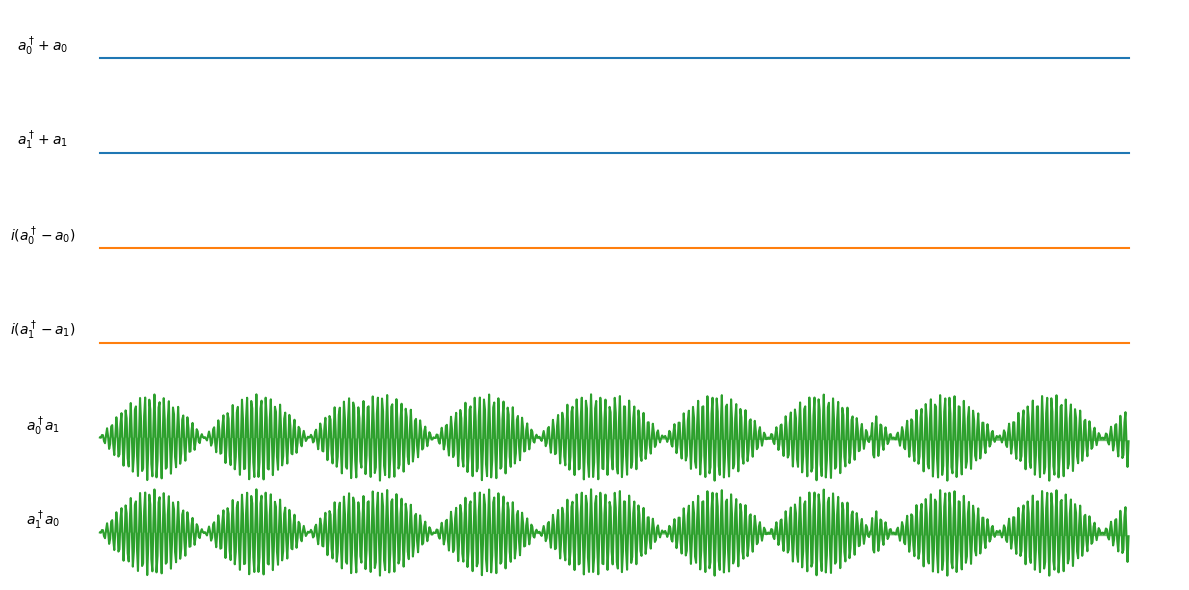

In [44]:
myprocessor.plot_pulses()
plt.show()

In [45]:
prop = myprocessor.run_propagator()
M = project_on_qubit(prop[-1])

/Users/shahnawaz/miniconda3/envs/qip/lib/python3.10/site-packages/qutip_qip/pulse.py:667: ComplexWarning: Casting complex values to real discards the imaginary part
  new_coeff[new_ind] = old_coeffs[old_ind]


### Compute propagator

In [46]:
U = circuit.compute_unitary()
U

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]

In [47]:
average_gate_fidelity(U,M)

0.8496798079047914

### Quantum state simulation

In [48]:
# Define a circuit and run the simulation
num_qubits = 2

circuit = QubitCircuit(num_qubits)
circuit.add_gate("CZ", controls=0, targets=1)

myprocessor = ChalmersQubits(num_qubits) 
tlist, coeffs = myprocessor.load_circuit(circuit)

0.006283185307179587


In [53]:
options = Options(store_states=True)
initial_state = tensor(basis(3,1),basis(3,1))
ket20 = tensor(basis(3,2),basis(3,0))
e_ops = [ket2dm(initial_state),ket2dm(ket20)]
result = myprocessor.run_state(initial_state, e_ops=e_ops, options=options)

/Users/shahnawaz/miniconda3/envs/qip/lib/python3.10/site-packages/qutip_qip/pulse.py:667: ComplexWarning: Casting complex values to real discards the imaginary part
  new_coeff[new_ind] = old_coeffs[old_ind]


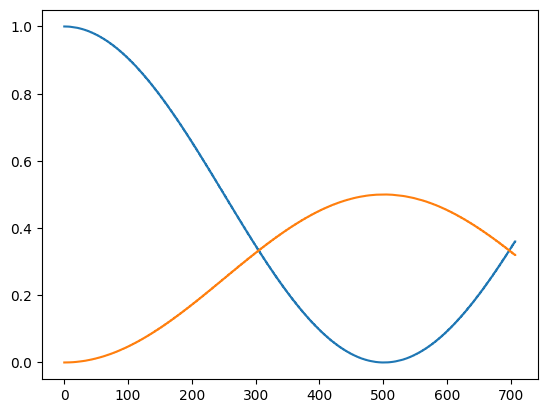

In [54]:
plt.plot(result.times,result.expect[0])
plt.plot(result.times,result.expect[1])

## Test XY-gate

In [55]:
# Define a circuit and run the simulation
num_qubits = 2

circuit = QubitCircuit(num_qubits)
circuit.add_gate("XY", controls=0, targets=1)

myprocessor = ChalmersQubits(num_qubits) 
tlist, coeffs = myprocessor.load_circuit(circuit)

0.006283185307179587


In [56]:
# Compute the propagator
prop = myprocessor.run_propagator(qc=circuit)

0.006283185307179587


In [57]:
# Project it onto the qubit subspace.
project_on_qubit(prop[-1])

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 1.        +0.00000000e+00j
  0.        +2.48202954e-08j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +2.48202954e-08j
  1.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.99999991+4.28413999e-04j]]

In [58]:
initial_state = tensor(basis(3,1),basis(3,0))
target_state = tensor(basis(3,1),basis(3,0))
result = myprocessor.run_state(initial_state, e_ops=[ket2dm(initial_state),ket2dm(target_state)], options=Options(store_states=True))
final_state = result.states[-1]

In [59]:
# All states for N levels in base N
base_N = [np.base_repr(i, base=3) for i in range(3**num_qubits)]
# All computational basis states
base_2 = [np.base_repr(i, base=2) for i in range(2**num_qubits)]
# Indices of of computational basis states in base N list
l = [base_N.index(i) for i in base_2]
# Project state onto quit subspace
qubit_state = Qobj([final_state.full()[i] for i in l], dims=[[2]*num_qubits,[1]*num_qubits])
initial_qubit_state = Qobj([initial_state.full()[i] for i in l], dims=[[2]*num_qubits,[1]*num_qubits])
qubit_state

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.+0.00000000e+00j]
 [0.-3.18202397e-06j]
 [1.+0.00000000e+00j]
 [0.+0.00000000e+00j]]

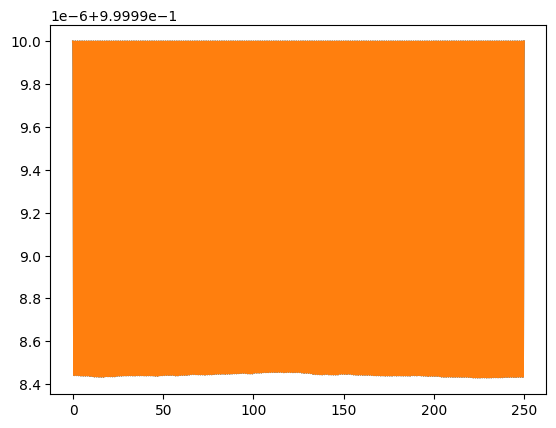

In [60]:
plt.plot(result.times,result.expect[0])
plt.plot(result.times,result.expect[1])

## Test Three Qubit-Gates

In [61]:
# Ideal gate
def cczs(args):
    theta, phi, gamma = args
    U = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, -np.exp(-1j*gamma)*np.sin(theta/2)**2 + np.cos(theta/2)**2, 
                                    (1/2)*(1 + np.exp(-1j*gamma))*np.exp(-1j*phi)*np.sin(theta), 0],
                  [0, 0, 0, 0, 0, (1/2)*(1 + np.exp(-1j*gamma))*np.exp(1j*phi)*np.sin(theta), 
                                    -np.exp(-1j*gamma)*np.cos(theta/2)**2 + np.sin(theta/2)**2, 0],
                  [0, 0, 0, 0, 0, 0, 0, -np.exp(1j*gamma)]], dtype="complex")
    return Qobj(U, dims=[[2]*3, [2]*3])

In [62]:
# Define a circuit and run the simulation
num_qubits = 3

circuit = QubitCircuit(num_qubits)
circuit.user_gates = {"CCZS": cczs}

# iFredkin-gate
circuit.add_gate("CCZS", targets=[0,1,2], arg_value=[np.pi/2,np.pi/2,0])
circuit.add_gate("CZ", controls=0, targets=2)

In [63]:
myprocessor = ChalmersQubits(num_qubits)
tlist, coeffs = myprocessor.load_circuit(circuit)

0.006283185307179587


In [64]:
prop = myprocessor.run_propagator()
M = project_on_qubit(prop[-1])

In [65]:
U = circuit.compute_unitary()
U

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

In [66]:
average_gate_fidelity(M,U)

0.6173326301246184

# Test 

In [67]:
def vd_real_circuit():
    num_qubits = 3
    circuit = QubitCircuit(num_qubits)
    circuit.user_gates = {"CCZS": cczs}

    # Hadamard Gate
    circuit.add_gate("RY", targets=0, arg_value=np.pi/2)
    circuit.add_gate("RX", targets=0, arg_value=np.pi)
    circuit.add_gate("GLOBALPHASE", targets=0, arg_value=np.pi/2)

    # iFredkin-gate
    circuit.add_gate("CCZS", targets=[0, 1, 2], arg_value=[np.pi/2, np.pi/2, 0])
    circuit.add_gate("CZ", controls=0, targets=2)

    # Hadamard Gate
    circuit.add_gate("RY", targets=0, arg_value=np.pi/2)
    circuit.add_gate("RX", targets=0, arg_value=np.pi)
    circuit.add_gate("GLOBALPHASE", targets=0, arg_value=np.pi/2)

    return circuit

def vd_imag_circuit():
    num_qubits = 3
    circuit = QubitCircuit(num_qubits)
    circuit.user_gates = {"CCZS": cczs}

    # Prepare |-i> as initial state
    circuit.add_gate("RX", targets=0, arg_value=np.pi/2)

    # iFredkin-gate
    circuit.add_gate("CCZS", targets=[0, 1, 2],
                     arg_value=[np.pi/2, np.pi/2, 0])
    circuit.add_gate("CZ", controls=0, targets=2)

    # Hadamard Gate
    circuit.add_gate("RY", targets=0, arg_value=np.pi/2)
    circuit.add_gate("RX", targets=0, arg_value=np.pi)
    circuit.add_gate("GLOBALPHASE", targets=0, arg_value=np.pi/2)
    return circuit

In [70]:
a = np.zeros((3,3),dtype="complex")
a[:2,:2] = rand_dm(2)
rho = Qobj(a)
(rho**2).tr()

0.8524648987117883

In [74]:
num_qubits = 3
initial_state = tensor(ket2dm(basis(3,0)),rho,rho)
myprocessor = ChalmersQubits(num_qubits)
res = myprocessor.run_state(initial_state, qc=vd_real_circuit())

U = vd_real_circuit().compute_unitary()
target_state = U * project_on_qubit(initial_state) * U.dag()

re_ideal = (sigmaz()*target_state.ptrace(0))
re = (sigmaz()*project_on_qubit(res.states[-1]).ptrace(0))

0.006283185307179587


/Users/shahnawaz/miniconda3/envs/qip/lib/python3.10/site-packages/qutip_qip/pulse.py:667: ComplexWarning: Casting complex values to real discards the imaginary part
  new_coeff[new_ind] = old_coeffs[old_ind]


In [75]:
#rho = rand_dm(3)
initial_state = tensor(ket2dm(basis(3,0)),rho,rho)
myprocessor = ChalmersQubits(num_qubits)
res = myprocessor.run_state(initial_state, qc=vd_imag_circuit())

U = vd_imag_circuit().compute_unitary()
target_state = U * project_on_qubit(initial_state) * U.dag()

im_ideal = (sigmaz()*target_state.ptrace(0))
im = (sigmaz()*project_on_qubit(res.states[-1]).ptrace(0))

0.006283185307179587


In [76]:
print((re_ideal+im_ideal).tr())
print((re+im).tr())
print((rho**2).tr())

0.852464898711788
0.6825559052053671
0.8524648987117883
